In [152]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001             # Weight of every type of data
        self.weights = [0.000125, 0.000010, 0.000200, 0.001]                                 # a1, a2, a3, mc
        self.lifetime = {'a1': 6, 'a2': 4, 'a3': 50, 'mc': 1000}                             # Max lifetime of the different data types
        self.total_c = 4
        self.total_s = 13
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.action_type = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        self.clusters = {
            'a1': randomized[:4],
            'a2': randomized[4:8],
            'a3': randomized[8:12],
            'mc': randomized[12:],
        }

        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self,data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity

        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            print(self.data[self.action_type[i]].values())
            print(self.latencies[self.action_device[i]])
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(self.clusters[operation.split('_')[1]],1)
            self.action_device.append(device[0])
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self): # baseline?
        allocation = []
        for i in self.data_types:
            allocation.append(random.sample(self.clusters[i],1)[0])
        self.data_allocation = allocation
        self.construct_dictionaries()

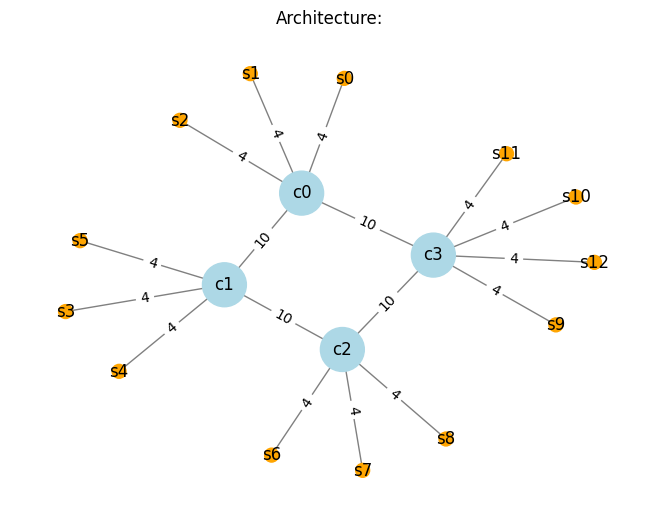

In [130]:
arch = Architecture()

In [146]:
arch.generate('a3')
arch.heart_beat()
arch.generate('ai_a3')
arch.heart_beat()
print(arch.data_types, arch.data_allocation, arch.data_times)
# arch.free_space()
print(arch.compute_total_latency())

['mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'mc', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3', 'a3'] ['s11', 's9', 's11', 's11', 's3', 's9', 's5', 's11', 's11', 's5', 's5', 's5', 's11', 's5', 's11', 's6', 's6', 's9', 's11', 's9', 's6', 's3', 's5', 's11', 's11', 's6', 's5', 's3', 's3', 's5', 's9', 's9', 's5', 's5', 's11', 's11', 's11', 's5', 's11', 

In [151]:
# print(arch.data_allocation)
# arch.compute_total_latency()
arch.greedy_algorithm()
print(arch.compute_total_latency())

dict_values([0, 0, 0, 0, 0, 0, 0, 27, 0, 14, 20, 0, 0, 15, 0, 15, 0])
{'c0': 24, 'c1': 14, 'c2': 4, 'c3': 14, 's0': 28, 's1': 28, 's2': 28, 's3': 18, 's4': 18, 's5': 18, 's6': 0, 's7': 8, 's8': 8, 's9': 18, 's10': 18, 's11': 18, 's12': 18}
dict_values([0, 0, 0, 0, 0, 0, 0, 27, 0, 14, 20, 0, 0, 15, 0, 15, 0])
{'c0': 14, 'c1': 4, 'c2': 14, 'c3': 24, 's0': 18, 's1': 18, 's2': 18, 's3': 0, 's4': 8, 's5': 8, 's6': 18, 's7': 18, 's8': 18, 's9': 28, 's10': 28, 's11': 28, 's12': 28}
dict_values([0, 0, 0, 0, 0, 0, 0, 27, 0, 14, 20, 0, 0, 15, 0, 15, 0])
{'c0': 14, 'c1': 24, 'c2': 14, 'c3': 4, 's0': 18, 's1': 18, 's2': 18, 's3': 28, 's4': 28, 's5': 28, 's6': 18, 's7': 18, 's8': 18, 's9': 0, 's10': 8, 's11': 8, 's12': 8}
dict_values([0, 0, 0, 0, 0, 0, 0, 27, 0, 14, 20, 0, 0, 15, 0, 15, 0])
{'c0': 14, 'c1': 24, 'c2': 14, 'c3': 4, 's0': 18, 's1': 18, 's2': 18, 's3': 28, 's4': 28, 's5': 28, 's6': 18, 's7': 18, 's8': 18, 's9': 8, 's10': 8, 's11': 0, 's12': 8}
dict_values([0, 0, 0, 0, 0, 0, 0, 27, 0, 1